### Main analysis of the similarity contexts based on the extracted target-analogue pairs
- Created by G Patlewicz
- Last Modified 22 February 2024
- Changes: Identified duplicative Derek alert vectors due to naming convention - this impacted the Derek pairwise similarities, thus a re-processing of the ML for the similarity contexts is merited. Error identified based on reviewer comments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
from scipy.spatial.distance import pdist, squareform
import sys

In [2]:
import re

In [3]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'
processed_dir = TOP + 'data/processed/'

In [4]:
df = pd.read_excel(external_dir+'reach_pairs_290623_mapped.xlsx', sheet_name = 'mapped', index_col = [0])

In [5]:
df.columns

Index(['UUID (dossier)', 'UUID (read-across application)',
       'UUID (source experimental study)', 'number of source studies',
       'endpoint (read-across application)',
       'study result type (read-across application)',
       'endpoint (source experimental study)',
       'study result type (source experimental study)',
       'guideline(s) (source experimental study)',
       'UUID (literature reference(s), source experimental study)',
       'UUID (test material, source experimental study)',
       'test material (source experimental study)', 'registered substance',
       'source_analogue', 'target_substance', 'source_id_tag',
       'source_IUPAC_name', 'source_CAS', 'source_SMILES', 'id_tag',
       'source_Query', 'source_DSSTox_Substance_Id',
       'source_DSSTox_Structure_Id', 'source_DSSTox_QC-Level',
       'source_Substance_Name', 'source_Substance_CASRN',
       'source_Substance_Type', 'source_Substance_Note',
       'source_Structure_SMILES', 'source_Structure_

In [6]:
df[['source_analogue', 'target_substance', 'source_id_tag',
       'source_IUPAC_name', 'source_CAS', 'source_SMILES', 'id_tag',
       'source_Query']]

,source_analogue,target_substance,source_id_tag,source_IUPAC_name,source_CAS,source_SMILES,id_tag,source_Query
0,"[{""reference substance type"": ""Constituent"", ""...","[{""UUID (reference substance)"": ""2fac5301-0864...",ID0,dibutyltin dichloride,683-18-1,[Cl-].[Cl-].CCCC[Sn+2]CCCC,ID0,683-18-1
1,"[{""reference substance type"": ""Constituent"", ""...","[{""UUID (reference substance)"": ""83c2cd5a-479e...",ID1,octadec-1-ene,112-88-9,CCCCCCCCCCCCCCCCC=C,ID1,112-88-9
2,"[{""reference substance type"": ""Constituent"", ""...","[{""UUID (reference substance)"": ""83c2cd5a-479e...",ID2,octadec-1-ene,112-88-9,CCCCCCCCCCCCCCCCC=C,ID2,112-88-9
3,"[{""reference substance type"": ""Constituent"", ""...","[{""UUID (reference substance)"": ""1da1f753-059f...",ID3,1-hexene,592-41-6,None,ID3,592-41-6
4,"[{""reference substance type"": ""Constituent"", ""...","[{""UUID (reference substance)"": ""77df4b47-a80d...",ID4,octadec-1-ene,112-88-9,CCCCCCCCCCCCCCCCC=C,ID4,112-88-9
...,...,...,...,...,...,...,...,...
5016,"[{""reference substance type"": ""Constituent"", ""...","[{""UUID (reference substance)"": ""b8c6d741-6622...",ID5016,NaN,NaN,NaN,ID5016,NaN
5017,"[{""reference substance type"": ""Constituent"", ""...","[{""UUID (reference substance)"": ""b8c6d741-6622...",ID5017,NaN,NaN,NaN,ID5017,NaN
5018,"[{""reference substance type"": ""Constituent"", ""...","[{""UUID (reference substance)"": ""b8b9e9fb-d871...",ID5018,sodium 4-undecylbenzenesulfonate,68411-30-3,None,ID5018,68411-30-3
5019,"[{""reference substance type"": ""Constituent"", ""...","[{""UUID (reference substance)"": ""c099c6f1-3f9a...",ID5019,Rosin ethylene glycol ester,68512-65-2,None,ID5019,68512-65-2


In [7]:
patts = ['target_', 'source_']

In [8]:
cols = [column for column in df.columns if any(re.search(p, column) for p in patts)]

In [9]:
df = df[cols]

In [10]:
df = df[['source_DSSTox_Substance_Id', 'source_DSSTox_Structure_Id',
       'source_DSSTox_QC-Level', 'source_Substance_Name',
       'source_Substance_CASRN', 'source_Substance_Type',
       'source_Substance_Note', 'source_Structure_SMILES',
       'source_Structure_InChI', 'source_Structure_InChIKey',
       'source_Structure_Formula', 'source_Structure_MolWt',
       'source_Structure_SMILES_2D-QSAR','target_DSSTox_Substance_Id',
       'target_DSSTox_Structure_Id', 'target_DSSTox_QC-Level',
       'target_Substance_Name', 'target_Substance_CASRN',
       'target_Substance_Type', 'target_Substance_Note',
       'target_Structure_SMILES', 'target_Structure_InChI',
       'target_Structure_InChIKey', 'target_Structure_Formula',
       'target_Structure_MolWt', 'target_Structure_SMILES_2D-QSAR' ]]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5021 entries, 0 to 5020
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   source_DSSTox_Substance_Id       4096 non-null   object 
 1   source_DSSTox_Structure_Id       2216 non-null   object 
 2   source_DSSTox_QC-Level           4096 non-null   object 
 3   source_Substance_Name            4096 non-null   object 
 4   source_Substance_CASRN           4096 non-null   object 
 5   source_Substance_Type            4096 non-null   object 
 6   source_Substance_Note            1357 non-null   object 
 7   source_Structure_SMILES          2223 non-null   object 
 8   source_Structure_InChI           2216 non-null   object 
 9   source_Structure_InChIKey        2216 non-null   object 
 10  source_Structure_Formula         2216 non-null   object 
 11  source_Structure_MolWt           2216 non-null   float64
 12  source_Structure_SMI

In [17]:
#df.target_DSSTox_Substance_Id.unique()

In [18]:
df2 = df.dropna(subset=['source_DSSTox_Substance_Id', 'target_DSSTox_Substance_Id'])

In [19]:
df2 = df2[df2['source_DSSTox_Substance_Id'] != df2['target_DSSTox_Substance_Id']]

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3655 entries, 0 to 5020
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   source_DSSTox_Substance_Id       3655 non-null   object 
 1   source_DSSTox_Structure_Id       1968 non-null   object 
 2   source_DSSTox_QC-Level           3655 non-null   object 
 3   source_Substance_Name            3655 non-null   object 
 4   source_Substance_CASRN           3655 non-null   object 
 5   source_Substance_Type            3655 non-null   object 
 6   source_Substance_Note            1223 non-null   object 
 7   source_Structure_SMILES          1975 non-null   object 
 8   source_Structure_InChI           1968 non-null   object 
 9   source_Structure_InChIKey        1968 non-null   object 
 10  source_Structure_Formula         1968 non-null   object 
 11  source_Structure_MolWt           1968 non-null   float64
 12  source_Structure_SMI

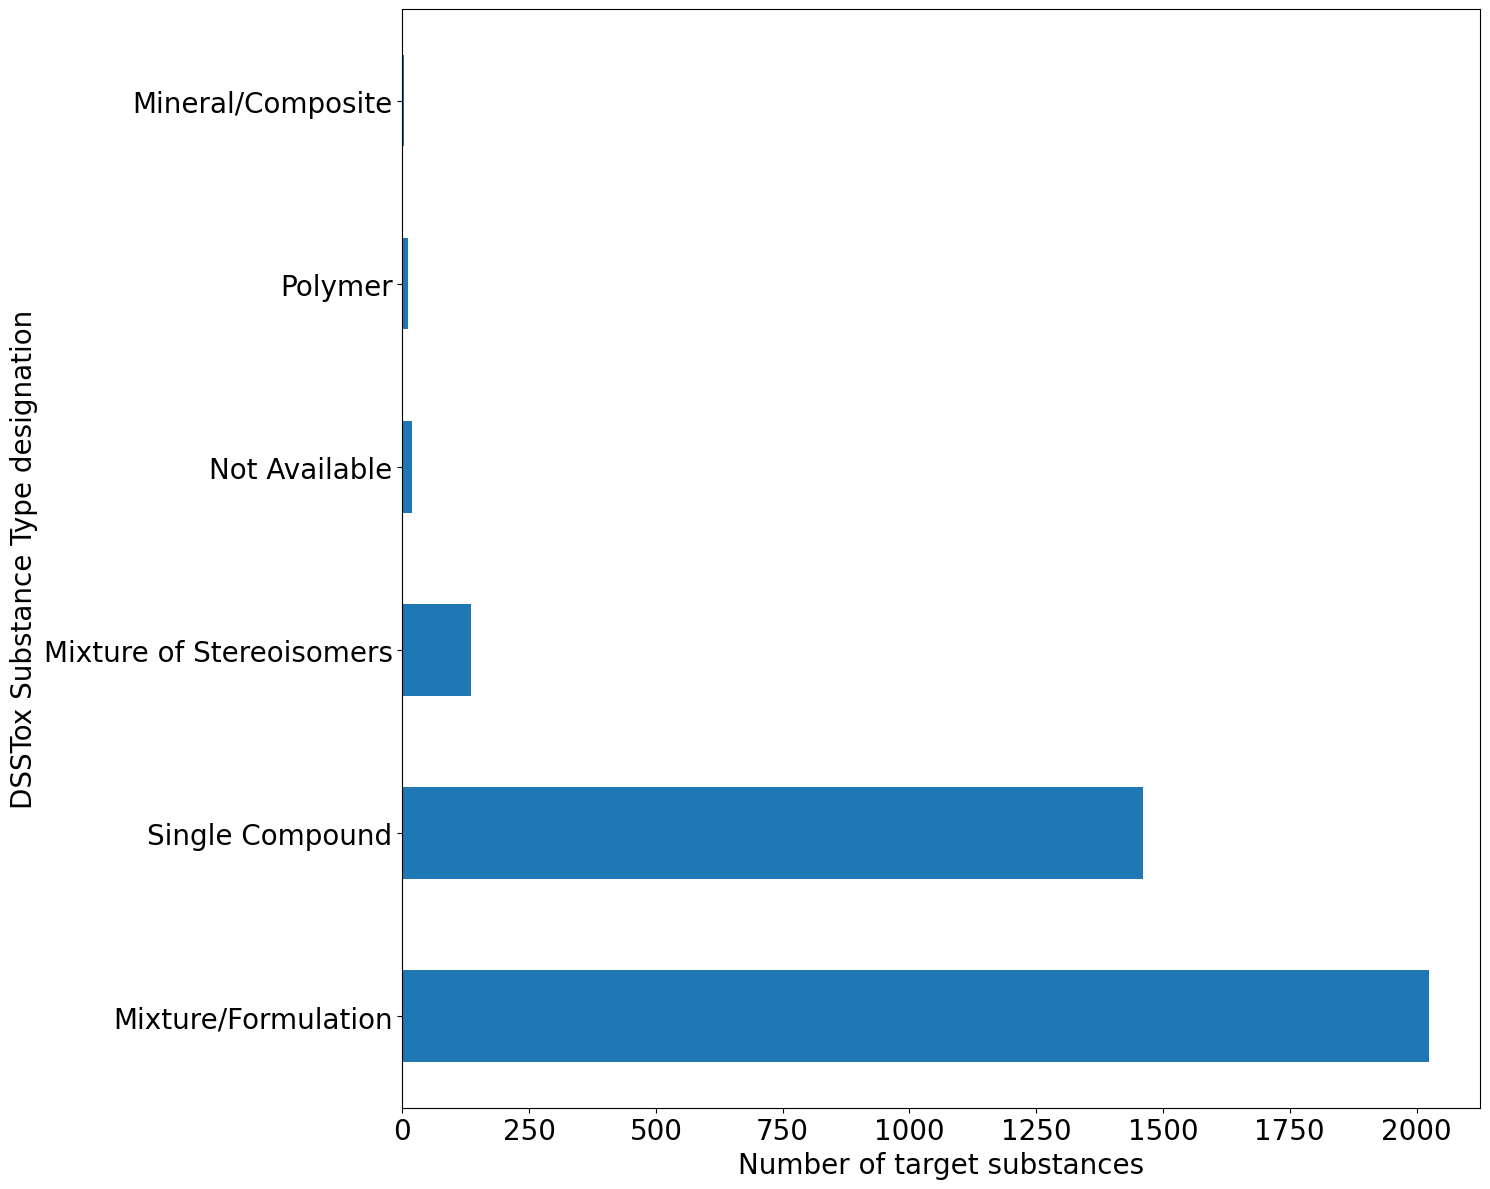

In [21]:
#| label: fig-targetcounts
#| fig-cap: "Profile of DSSTox substance type for target substances"
plt.figure(figsize = (15,12))
df2.target_Substance_Type.value_counts(dropna = False).drop_duplicates().plot.barh()
plt.xlabel('Number of target substances', fontsize = 20)
plt.ylabel('DSSTox Substance Type designation', fontsize = 20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tight_layout()
#plt.savefig(figures_dir+'Targets_count_300623.png', dpi = 300)

In [22]:
df2.target_Substance_Type.value_counts(dropna = False, normalize = True)

Mixture/Formulation         0.553762
Single Compound             0.399453
Mixture of Stereoisomers    0.037209
Not Available               0.005472
Polymer                     0.003283
Mineral/Composite           0.000821
Name: target_Substance_Type, dtype: float64

In [23]:
df2[df2['target_Substance_Type'] == 'Mixture/Formulation']['target_Substance_Name'].unique().tolist()[0:10]

['Alkenes, C13-14',
 'Hydrocarbons, C12-30, olefin-rich, ethylene polymn. by-product',
 'Hexene',
 'Hydrocarbons, C16-C20, n-alkanes, isoalkanes, cyclics,',
 'Resin acids and Rosin acids, hydrogenated, Me esters',
 'Alkenes, C>8',
 'Alkenes, C10-14-branched and linear, C12-rich',
 'Castor oil, ester with trimethylolpropane',
 'Alkenes, C9-13-branched, C10-rich',
 'Alkenes, C21-32-branched and linear']

In [24]:
df2[df2['target_Substance_Type'] == 'Mixture/Formulation']['target_Substance_Name'].value_counts()

Alkenes, C11-12                                                                                         137
Alkenes, C13-14                                                                                         100
Hexadecene                                                                                               99
Octadecene                                                                                               95
Alkenes, C8-10, C9-rich                                                                                  75
                                                                                                       ... 
Hexanedioic acid, mixed esters with decanoic acid, heptanoic acid, octanoic acid and pentaerythritol      1
Peptones, beef                                                                                            1
Rosmarinus officinalis leaf extract                                                                       1
Quaternary ammonium compound

In [25]:
reach_pairs_smi = df2.dropna(subset=['source_Structure_SMILES',  'target_Structure_SMILES'])
reach_pairs_smi = reach_pairs_smi[reach_pairs_smi['source_DSSTox_Substance_Id'] != reach_pairs_smi['target_DSSTox_Substance_Id']]

In [26]:
reach_pairs_smi.target_DSSTox_Substance_Id.nunique()

350

In [27]:
reach_pairs_smi = reach_pairs_smi.drop_duplicates()

In [28]:
qsar_ready = pd.read_csv(external_dir+'all_dtxsid_dedup_Summary_file.csv')

In [29]:
mydict = {k:v for k,v in zip(qsar_ready['Molecule name'], qsar_ready['Canonical_QSARr'])}

In [30]:
mydict['DTXSID8027292'] = 'CCCC[Sn](Cl)(Cl)CCCC'

In [31]:
mydict['DTXSID4027315'] = 'CCCC[Sn](=O)CCCC'

In [32]:
mydict['DTXSID0029210'] = 'CCCC[Sn](Cl)(Cl)Cl'

In [33]:
mydict['DTXSID4044797'] = 'CCCC[Sn](O)(O)Cl'

In [34]:
mydict['DTXSID6029628'] = 'CCCCCCCC[Sn](=O)CCCCCCCC'

In [35]:
mydict['DTXSID701020955'] = 'CCCCCCCC[Sn](CCCCCCCC)(OC(=O)C(CC)CCCC)OC(=O)C(CC)CCCC'

In [36]:
mydict['DTXSID1020194'] = 'OB(O)O'

In [37]:
mydict['DTXSID2041676'] = 'ClB(Cl)Cl'

In [38]:
len(mydict)

655

In [39]:
reach_pairs_smi['source_qsarsmi'] = reach_pairs_smi['source_DSSTox_Substance_Id'].apply(lambda x: mydict[x] if x in mydict.keys() else np.nan)

In [40]:
reach_pairs_smi['target_qsarsmi'] = reach_pairs_smi['target_DSSTox_Substance_Id'].apply(lambda x: mydict[x] if x in mydict.keys() else np.nan)

In [41]:
reach_pairs_smi.columns

Index(['source_DSSTox_Substance_Id', 'source_DSSTox_Structure_Id',
       'source_DSSTox_QC-Level', 'source_Substance_Name',
       'source_Substance_CASRN', 'source_Substance_Type',
       'source_Substance_Note', 'source_Structure_SMILES',
       'source_Structure_InChI', 'source_Structure_InChIKey',
       'source_Structure_Formula', 'source_Structure_MolWt',
       'source_Structure_SMILES_2D-QSAR', 'target_DSSTox_Substance_Id',
       'target_DSSTox_Structure_Id', 'target_DSSTox_QC-Level',
       'target_Substance_Name', 'target_Substance_CASRN',
       'target_Substance_Type', 'target_Substance_Note',
       'target_Structure_SMILES', 'target_Structure_InChI',
       'target_Structure_InChIKey', 'target_Structure_Formula',
       'target_Structure_MolWt', 'target_Structure_SMILES_2D-QSAR',
       'source_qsarsmi', 'target_qsarsmi'],
      dtype='object')

In [42]:
#reach_pairs_smi['source_Structure_SMILES_2D-QSAR'].equals(reach_pairs_smi[ 'source_qsarsmi'])

In [43]:
reach_pairs_smi.drop(['source_Structure_SMILES_2D-QSAR','target_Structure_SMILES_2D-QSAR'], axis = 1, inplace = True)

In [44]:
reach_pairs_smi

,source_DSSTox_Substance_Id,source_DSSTox_Structure_Id,source_DSSTox_QC-Level,source_Substance_Name,source_Substance_CASRN,source_Substance_Type,source_Substance_Note,source_Structure_SMILES,source_Structure_InChI,source_Structure_InChIKey,...,target_Substance_CASRN,target_Substance_Type,target_Substance_Note,target_Structure_SMILES,target_Structure_InChI,target_Structure_InChIKey,target_Structure_Formula,target_Structure_MolWt,source_qsarsmi,target_qsarsmi
0,DTXSID8027292,DTXCID607292,DSSTox_High,Dibutyltin dichloride,683-18-1,Single Compound,NaN,CCCC[Sn](Cl)(Cl)CCCC,"InChI=1S/2C4H9.2ClH.Sn/c2*1-3-4-2;;;/h2*1,3-4H...",RJGHQTVXGKYATR-UHFFFAOYSA-L,...,818-08-6,Single Compound,NaN,CCCC[Sn](=O)CCCC,"InChI=1S/2C4H9.O.Sn/c2*1-3-4-2;;/h2*1,3-4H2,2H...",JGFBRKRYDCGYKD-UHFFFAOYSA-N,C8H18OSn,248.941,CCCC[Sn](Cl)(Cl)CCCC,CCCC[Sn](=O)CCCC
1,DTXSID3026932,DTXCID106932,DSSTox_High,1-Octadecene,112-88-9,Single Compound,NaN,CCCCCCCCCCCCCCCCC=C,InChI=1S/C18H36/c1-3-5-7-9-11-13-15-17-18-16-1...,CCCMONHAUSKTEQ-UHFFFAOYSA-N,...,629-73-2,Single Compound,NaN,CCCCCCCCCCCCCCC=C,InChI=1S/C16H32/c1-3-5-7-9-11-13-15-16-14-12-1...,GQEZCXVZFLOKMC-UHFFFAOYSA-N,C16H32,224.432,CCCCCCCCCCCCCCCCC=C,CCCCCCCCCCCCCCC=C
16,DTXSID4025402,DTXCID105402,DSSTox_High,1-Hexene,592-41-6,Single Compound,NaN,CCCCC=C,"InChI=1S/C6H12/c1-3-5-6-4-2/h3H,1,4-6H2,2H3\nA...",LIKMAJRDDDTEIG-UHFFFAOYSA-N,...,112-41-4,Single Compound,NaN,CCCCCCCCCCC=C,InChI=1S/C12H24/c1-3-5-7-9-11-12-10-8-6-4-2/h3...,CRSBERNSMYQZNG-UHFFFAOYSA-N,C12H24,168.324,CCCCC=C,CCCCCCCCCCC=C
19,DTXSID2020630,DTXCID20630,DSSTox_High,Sodium fluoride,7681-49-4,Single Compound,From the CAMEO dataset: https://cameochemicals...,[F-].[Na+],InChI=1S/FH.Na/h1H;/q;+1/p-1\nAuxInfo=1/1/N:2;...,PUZPDOWCWNUUKD-UHFFFAOYSA-M,...,7789-75-5,Single Compound,NaN,[F-].[F-].[Ca++],InChI=1S/Ca.2FH/h;2*1H/q+2;;/p-2\nAuxInfo=1/1/...,WUKWITHWXAAZEY-UHFFFAOYSA-L,CaF2,78.075,NaN,NaN
20,DTXSID3026932,DTXCID106932,DSSTox_High,1-Octadecene,112-88-9,Single Compound,NaN,CCCCCCCCCCCCCCCCC=C,InChI=1S/C18H36/c1-3-5-7-9-11-13-15-17-18-16-1...,CCCMONHAUSKTEQ-UHFFFAOYSA-N,...,1120-36-1,Single Compound,NaN,CCCCCCCCCCCCC=C,InChI=1S/C14H28/c1-3-5-7-9-11-13-14-12-10-8-6-...,HFDVRLIODXPAHB-UHFFFAOYSA-N,C14H28,196.378,CCCCCCCCCCCCCCCCC=C,CCCCCCCCCCCCC=C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999,DTXSID6024834,DTXCID504834,DSSTox_High,(2E)-3-Phenylprop-2-enal,14371-10-9,Single Compound,double bond E,O=C\C=C\C1=CC=CC=C1,InChI=1S/C9H8O/c10-8-4-7-9-5-2-1-3-6-9/h1-8H/b...,KJPRLNWUNMBNBZ-QPJJXVBHSA-N,...,93-61-8,Single Compound,SRS/ChemID matched; SRS trust index 3,CN(C=O)C1=CC=CC=C1,"InChI=1S/C8H9NO/c1-9(7-10)8-5-3-2-4-6-8/h2-7H,...",JIKUXBYRTXDNIY-UHFFFAOYSA-N,C8H9NO,135.166,O=CC=CC1C=CC=CC=1,CN(C=O)C1C=CC=CC=1
5001,DTXSID80159080,DTXCID8081571,Public_Medium,"Sulfuric acid, manganese(2+) salt (1:1), hepta...",13492-24-5,Single Compound,Loaded based on no conflicts with this data in...,O.O.O.O.O.O.O.[Mn++].[O-]S([O-])(=O)=O,"InChI=1S/Mn.H2O4S.7H2O/c;1-5(2,3)4;;;;;;;/h;(H...",OQTQHQORDRKHFW-UHFFFAOYSA-L,...,10377-66-9,Single Compound,NaN,[Mn++].[O-][N+]([O-])=O.[O-][N+]([O-])=O,InChI=1S/Mn.2NO3/c;2*2-1(3)4/q+2;2*-1\nAuxInfo...,MIVBAHRSNUNMPP-UHFFFAOYSA-N,MnN2O6,178.946,NaN,NaN
5007,DTXSID1021324,DTXCID901324,DSSTox_High,"1,1,1,2-Tetrafluoroethane",811-97-2,Single Compound,NaN,FCC(F)(F)F,"InChI=1S/C2H2F4/c3-1-2(4,5)6/h1H2\nAuxInfo=1/0...",LVGUZGTVOIAKKC-UHFFFAOYSA-N,...,75-37-6,Single Compound,NaN,CC(F)F,"InChI=1S/C2H4F2/c1-2(3)4/h2H,1H3\nAuxInfo=1/0/...",NPNPZTNLOVBDOC-UHFFFAOYSA-N,C2H4F2,66.051,FCC(F)(F)F,CC(F)F
5008,DTXSID3026514,DTXCID506514,DSSTox_High,Phthalimide,85-41-6,Single Compound,Metabolite of Captan;,O=C1NC(=O)C2=C1C=CC=C2,InChI=1S/C8H5NO2/c10-7-5-3-1-2-4-6(5)8(11)9-7/...,XKJCHHZQLQNZHY-UHFFFAOYSA-N,...,6925-69-5,Single Compound,SRS/ChemID matched; SRS trust index 3,O=C1N2C(=NC3=C4C(C=CC=C24)=CC=C3)C2=CC=CC=C12,InChI=1S/C18H10N2O/c21-18-13-8-2-1-7-12(13)17-...,XFYQEBBUVNLYBR-UHFFFAOYSA-N,C18H10N2O,2

In [45]:
reach_pairs_qsmi = reach_pairs_smi.dropna(subset=['source_qsarsmi', 'target_qsarsmi'])

In [46]:
reach_pairs_qsmi = reach_pairs_qsmi.drop_duplicates()

In [47]:
reach_pairs_qsmi.shape

(389, 26)

In [48]:
reach_pairs_qsmi.rename(columns = {'source_DSSTox_Substance_Id': 'source_dtxsid', 'target_DSSTox_Substance_Id': 'target_dtxsid'}, inplace = True)

In [49]:
reach_pairs_qsmi.columns

Index(['source_dtxsid', 'source_DSSTox_Structure_Id', 'source_DSSTox_QC-Level',
       'source_Substance_Name', 'source_Substance_CASRN',
       'source_Substance_Type', 'source_Substance_Note',
       'source_Structure_SMILES', 'source_Structure_InChI',
       'source_Structure_InChIKey', 'source_Structure_Formula',
       'source_Structure_MolWt', 'target_dtxsid', 'target_DSSTox_Structure_Id',
       'target_DSSTox_QC-Level', 'target_Substance_Name',
       'target_Substance_CASRN', 'target_Substance_Type',
       'target_Substance_Note', 'target_Structure_SMILES',
       'target_Structure_InChI', 'target_Structure_InChIKey',
       'target_Structure_Formula', 'target_Structure_MolWt', 'source_qsarsmi',
       'target_qsarsmi'],
      dtype='object')

In [50]:
reach_pairs_qsmi.target_dtxsid.nunique()

270

In [51]:
#reach_pairs_qsmi.to_csv(processed_dir+'reach_pairs_qsmi.csv')

In [52]:
reach_pairs_qsmi.source_dtxsid.nunique()

259

In [53]:
target_dict = {}
for i, group in reach_pairs_qsmi.groupby('target_dtxsid'):
    v = list(set(group['source_dtxsid']))
    target_dict[i] = v

In [54]:
len(target_dict)

270

In [55]:
len({k:len(v) for k,v in target_dict.items() if len(v) == 1})

182

In [56]:
len({k:len(v) for k,v in target_dict.items() if len(v) > 1})

88

In [57]:
from collections import Counter

In [58]:
d = Counter({k:len(v) for k,v in target_dict.items()}.values())
d = dict(d)

In [59]:
range(1, len(d)+1)

range(1, 5)

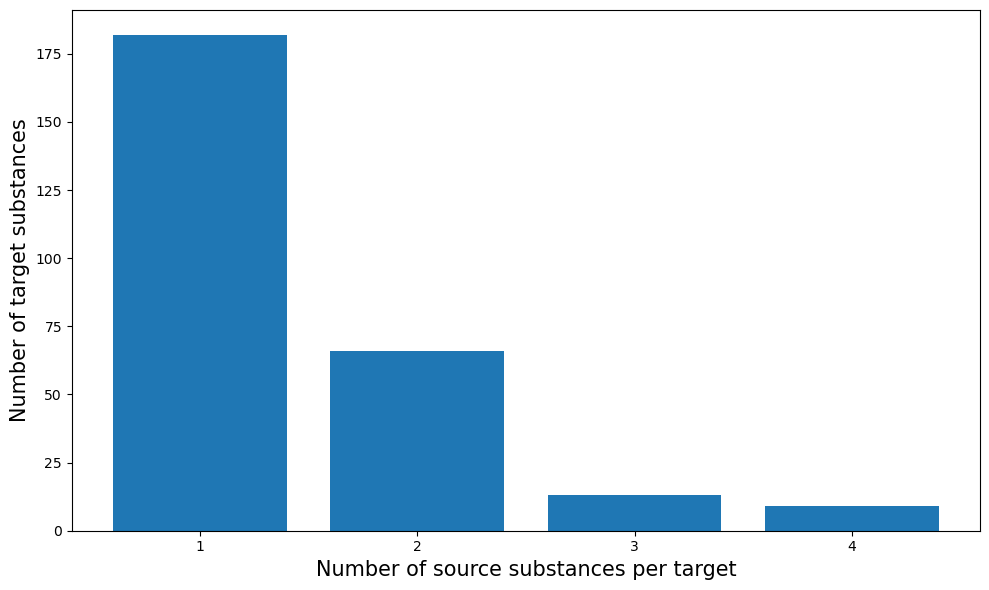

In [60]:
f, ax = plt.subplots(figsize = (10,6))

names = list(d.keys())
values = list(d.values())

#empty_xtick_labels = [''] * len(current_xtick_labels)
#new_xtick_labels = [label if label in names else '' for label in current_xtick_labels]
#print(new_xtick_labels)
ax.bar(names, values)
#ax.invert_xaxis()
ax.set_xticks(names, labels = names)
ax.set_ylabel('Number of target substances', fontsize = 15)
ax.set_xlabel('Number of source substances per target', fontsize = 15)
#plt.xticks(range(len(current_xtick_labels)), new_xtick_labels)
plt.tight_layout()
#f.savefig(figures_dir+'target_source_count_300623.png', dpi = 300)

In [61]:
def mk_fp(df, col1 = 'name', col2 = 'smiles'):

    '''
    Function to create a Morgan FP  of length 1024 and radius 3. Input file is expecting a dtxsid and smiles column in a df. 
    Expects dtxsid as identifier and smiles as SMILES.
    Returns df of index as dtxsid values and columns as 1024 morgan FP
    '''

    MOLS = dict(zip(df[col1], df[col2]))
    MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
    MOLS = {i:j for i,j in MOLS.items() if j}
    FP0 = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,1024)) for i in MOLS.values()])
    FP0.index = MOLS.keys()
    FP0.columns = ['mrgn_%d'%i for i in FP0.columns]
    return FP0

In [62]:
def mk_httr(df, col1 = 'name', col2 = 'smiles'):

    '''
    Function to create a Morgan FP  of length 1024 and radius 3. Input file is expecting a dtxsid and smiles column in a df. 
    Expects dtxsid as identifier and smiles as SMILES.
    Returns df of index as dtxsid values and columns as 1024 morgan FP
    '''

    MOLS = dict(zip(df[col1], df[col2]))
    MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
    MOLS = {i:j for i,j in MOLS.items() if j}
    FP0 = pd.DataFrame([np.array(AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect(i)) for i in MOLS.values()])
    FP0.index = MOLS.keys()
    FP0.columns = ['mrgn_%d'%i for i in FP0.columns]
    return FP0

In [63]:
def distance_matrix(df):
    '''
    Function to create a pairwise square distance matrix using the Jaccard index
    '''
    D_mgrn = pd.DataFrame(squareform(pdist(df, 'jaccard')), columns = df.index, index = df.index)

    return D_mgrn

In [64]:
target_fp = mk_fp(reach_pairs_qsmi, col1 = 'target_dtxsid', col2 = 'target_qsarsmi')

In [65]:
#target_fp.to_csv(processed_dir+'targets_020723.csv')

In [66]:
source_fp = mk_fp(reach_pairs_qsmi, col1 = 'source_dtxsid', col2 = 'source_qsarsmi')

In [67]:
X = pd.concat([target_fp, source_fp])

In [68]:
X.shape

(529, 1024)

In [69]:
X = X[~X.index.duplicated(keep='first')]

In [70]:
X.shape

(510, 1024)

Exploring if any impact using torsion FP

In [71]:
target_fp_httr = mk_httr(reach_pairs_qsmi, col1 = 'target_dtxsid', col2 = 'target_qsarsmi')
source_fp_httr = mk_httr(reach_pairs_qsmi, col1 = 'source_dtxsid', col2 = 'source_qsarsmi')
X1 = pd.concat([target_fp_httr, source_fp_httr])
X1 = X1[~X1.index.duplicated(keep='first')]
D1 = distance_matrix(X1)
S1 = 1 -D1

In [72]:
sim_dict1 = {}
for k, v in target_dict.items():
    a = S1[S1.index == k][v].values[0]
    sim_dict1[k] = a


In [73]:
np.median(list({k:v[0] for k,v in sim_dict1.items()}.values()))

0.5108695652173914

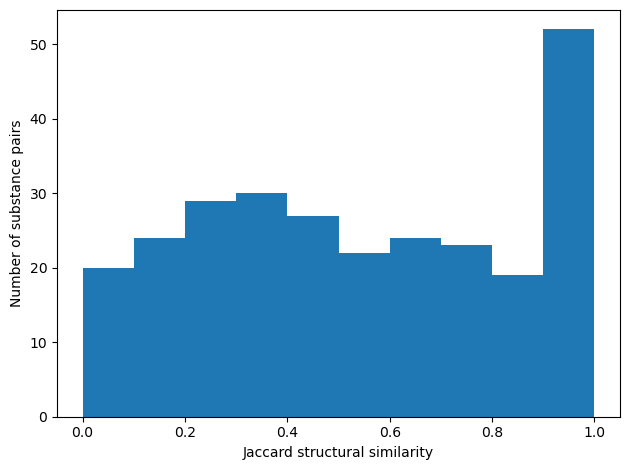

In [74]:
plt.hist({k:v[0] for k,v in sim_dict1.items()}.values())
plt.xlabel('Jaccard structural similarity')
plt.ylabel('Number of substance pairs')
plt.tight_layout()

Computing the distance matrix for the Morgan chemical FP

In [75]:
D = distance_matrix(X)

In [76]:
S = 1 -D

In [77]:
sim_dict = {}
for k, v in target_dict.items():
    a = S[S.index == k][v].values[0]
    sim_dict[k] = a


In [78]:
np.median(list({k:v[0] for k,v in sim_dict.items()}.values()))

0.42988204456094364

In [79]:
target_dict['DTXSID0027195']

['DTXSID9025796']

Which targets are associated with a high similarity

In [80]:
#{k:v for k,v in sim_dict.items() if all( e >0.8 for e in v)}

In [81]:
#{k:v for k,v in sim_dict.items() if all( e == 1 for e in v)}

In [82]:
target_dict['DTXSID7052280']

['DTXSID3026930']

In [83]:
target_dict['DTXSID6035491']

['DTXSID9032537']

In [84]:
sim_dict['DTXSID501031491']

array([0.89473684])

In [85]:
reach_pairs_qsmi[reach_pairs_qsmi['target_dtxsid'] == 'DTXSID6035491'][[ 'target_Substance_Name', 'target_dtxsid', 'source_Substance_Name','source_dtxsid']]

,target_Substance_Name,target_dtxsid,source_Substance_Name,source_dtxsid
2704,Dioctyldimethylammonium chloride,DTXSID6035491,Didecyldimethylammonium chloride,DTXSID9032537


In [86]:
reach_pairs_qsmi[reach_pairs_qsmi['target_dtxsid'] == 'DTXSID7052280'][[ 'target_Substance_Name', 'target_dtxsid', 'source_Substance_Name','source_dtxsid']]

,target_Substance_Name,target_dtxsid,source_Substance_Name,source_dtxsid
1172,Calcium octanoate,DTXSID7052280,Docosanoic acid,DTXSID3026930


In [87]:
reach_pairs_qsmi[reach_pairs_qsmi['target_dtxsid'] == 'DTXSID501031491'][['source_Substance_Name', 'target_Substance_Name']]

,source_Substance_Name,target_Substance_Name
943,"1,6-Diisocyanatohexane","Pentane, 1,​5-​diisocyanato-"


Substances with very low similarities

In [88]:
{k:v for k,v in sim_dict.items() if all( e <0.4 for e in v)}

{'DTXSID001014636': array([0.37777778]),
 'DTXSID00204642': array([0.06896552, 0.23529412]),
 'DTXSID0024050': array([0.07692308, 0.2       ]),
 'DTXSID0027644': array([0.3]),
 'DTXSID0052590': array([0.15873016, 0.16666667]),
 'DTXSID0059089': array([0.26315789, 0.26315789, 0.20930233]),
 'DTXSID00924535': array([0.22222222]),
 'DTXSID10166505': array([0.28571429]),
 'DTXSID1020859': array([0.25      , 0.23684211]),
 'DTXSID10223506': array([0.28947368, 0.21621622]),
 'DTXSID1025308': array([0.19047619]),
 'DTXSID1026378': array([0.14285714]),
 'DTXSID1027504': array([0.35483871]),
 'DTXSID1027974': array([0.10204082]),
 'DTXSID1040114': array([0.30434783, 0.35714286]),
 'DTXSID1044512': array([0.28571429]),
 'DTXSID1044518': array([0.18367347, 0.16666667, 0.19607843]),
 'DTXSID1049433': array([0.15517241, 0.18181818]),
 'DTXSID1052456': array([0.19354839]),
 'DTXSID10861720': array([0.31372549]),
 'DTXSID10889383': array([0.32258065, 0.32258065, 0.32258065]),
 'DTXSID20190558': array

In [89]:
reach_pairs_qsmi[reach_pairs_qsmi['target_dtxsid'] == 'DTXSID001014636'][['target_Substance_Name', 'target_dtxsid', 'source_Substance_Name','source_dtxsid']]

,target_Substance_Name,target_dtxsid,source_Substance_Name,source_dtxsid
4492,1-(2-Hydroxy-3-sulphonatopropyl)pyridinium,DTXSID001014636,3-(Pyridinium-1-yl)propane-1-sulfonate,DTXSID3044592


In [90]:
reach_pairs_qsmi[reach_pairs_qsmi['target_dtxsid'] == 'DTXSID9057761'][['target_Substance_Name', 'target_dtxsid', 'source_Substance_Name','source_dtxsid']]

,target_Substance_Name,target_dtxsid,source_Substance_Name,source_dtxsid
3919,1-(3-Chlorophenyl)-4-(3-chloropropyl)piperazin...,DTXSID9057761,1-Methylpiperazine,DTXSID4021898


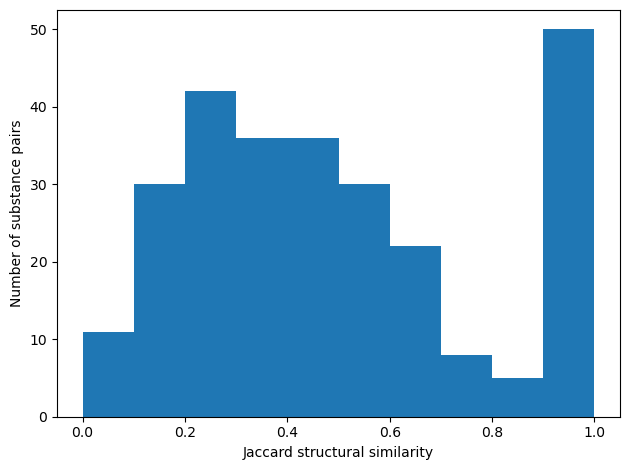

In [91]:
plt.hist({k:v[0] for k,v in sim_dict.items()}.values())
plt.xlabel('Jaccard structural similarity')
plt.ylabel('Number of substance pairs')
plt.tight_layout()
plt.savefig(figures_dir+'Tanimoto_SSsimilarity_source_220224.png', dpi = 300)

In [92]:
new_df = pd.DataFrame({k:v for k,v in sim_dict.items() if len(v) >1}.items())
new_df['meds'] = [np.median(e) for e in new_df[1]]
new_df = new_df.sort_values(by = 'meds', ascending = False)

In [93]:
new_df[new_df[0] == 'DTXSID0025234']

,0,1,meds
2,DTXSID0025234,"[0.47058823529411764, 0.134020618556701, 0.544...",0.470588


In [94]:
new_df[new_df[0] == 'DTXSID9068295']

,0,1,meds
87,DTXSID9068295,"[0.2191780821917808, 0.41463414634146345, 0.81...",0.414634


In [95]:
target_dict['DTXSID0025234']

['DTXSID9025328', 'DTXSID6052031', 'DTXSID7021233']

In [96]:
reach_pairs_qsmi[reach_pairs_qsmi['target_dtxsid']=='DTXSID0025234'][['target_Substance_Name', 'target_dtxsid', 'source_Substance_Name', 'source_dtxsid']]

,target_Substance_Name,target_dtxsid,source_Substance_Name,source_dtxsid
1376,Eosin,DTXSID0025234,FD&C Red 3,DTXSID7021233
1377,Eosin,DTXSID0025234,Fluorescein sodium,DTXSID9025328
2212,Eosin,DTXSID0025234,C.I. Pigment Orange 13,DTXSID6052031


In [97]:
reach_pairs_qsmi[reach_pairs_qsmi['target_dtxsid']=='DTXSID9068295'][['target_Substance_Name', 'target_dtxsid', 'source_Substance_Name', 'source_dtxsid']]['target_Substance_Name'].tolist()

['(4-(alpha-(4-(Dimethylamino)phenyl)benzylidene)cyclohexa-2,5-dien-1-ylidene)dimethylammonium acetate',
 '(4-(alpha-(4-(Dimethylamino)phenyl)benzylidene)cyclohexa-2,5-dien-1-ylidene)dimethylammonium acetate',
 '(4-(alpha-(4-(Dimethylamino)phenyl)benzylidene)cyclohexa-2,5-dien-1-ylidene)dimethylammonium acetate']

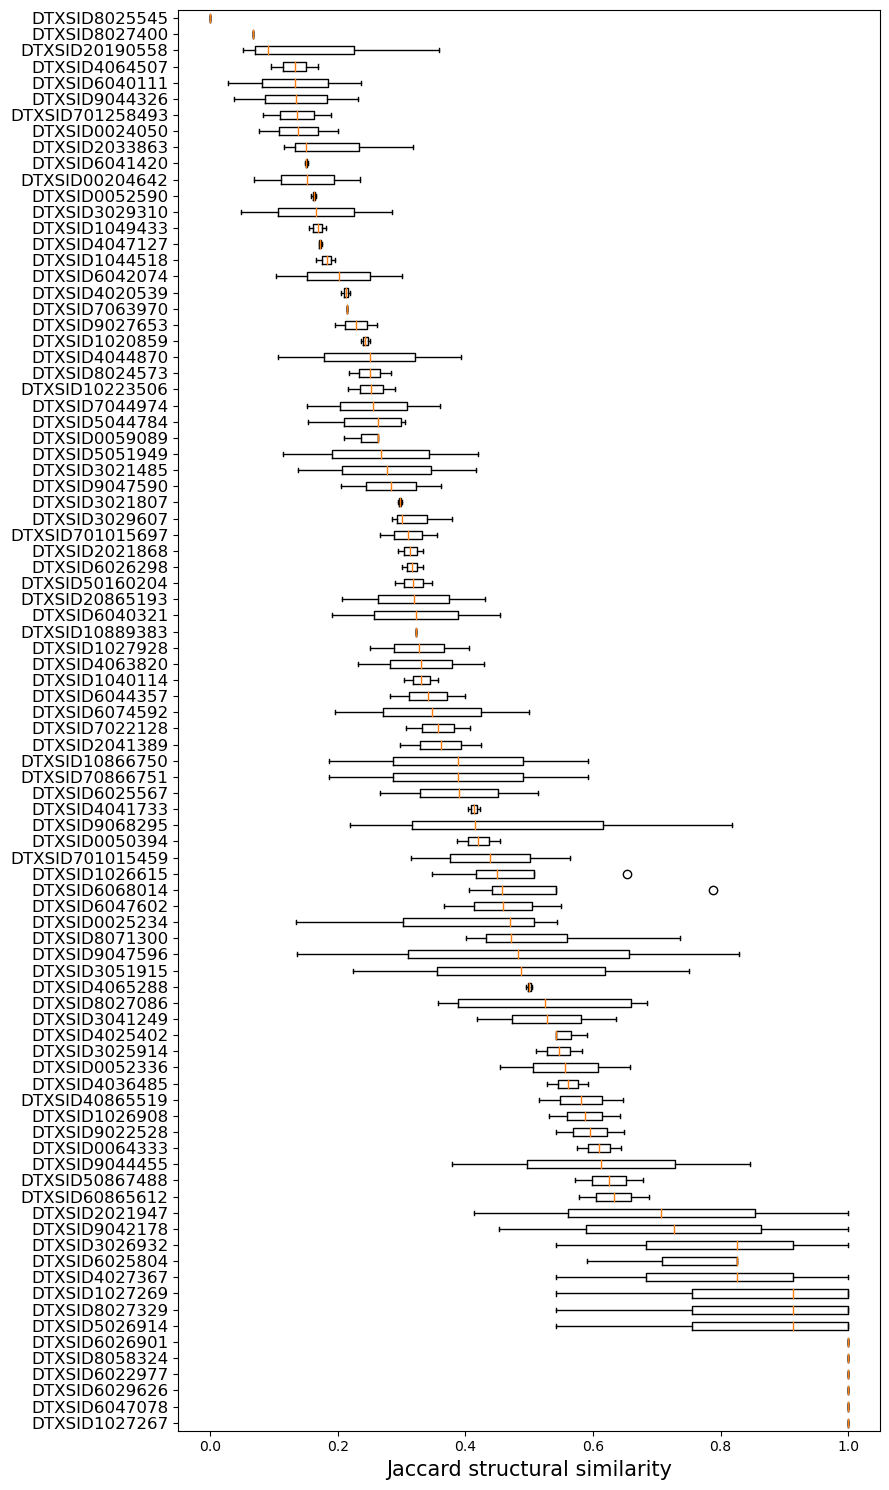

In [98]:
fig, ax = plt.subplots(figsize = (9,15))
labels, data = list(zip((new_df[0].values, new_df[1].values)))
ax.boxplot(data[0], vert = False)
plt.yticks(range(1, len(labels[0]) +1), labels[0], fontsize = 12)
plt.xlabel('Jaccard structural similarity', fontsize = 15)
plt.tight_layout()
fig.savefig(figures_dir+'Jaccard_SS_similarity_220224.png', dpi = 300)

In [99]:
opera_df = pd.read_csv(external_dir+'all_dtxsid_dedup-sdf_OPERA2.9Pred.csv')

In [100]:
opera_df = opera_df[['MoleculeID','MolWeight','nbHBdAcc',
 'ndHBdDon','LogP_pred',]]


In [101]:
opera_df = opera_df.set_index('MoleculeID')

In [102]:
opera_df

,MolWeight,nbHBdAcc,ndHBdDon,LogP_pred
MoleculeID,,,,
DTXSID3026932,252.281701,0,0,8.00
DTXSID4025402,84.093900,0,0,3.39
DTXSID6025804,112.125201,0,0,4.57
DTXSID9025796,128.156501,0,0,5.55
DTXSID0044496,170.130680,2,0,2.95
...,...,...,...,...
DTXSID6040111,116.083730,2,0,1.71
DTXSID4042206,253.240565,2,0,4.20
DTXSID501104446,512.158628,1,0,5.70


In [103]:
#opera_df['MW'] = opera_df['MolWeight'].apply(lambda x :x/500)
#opera_df['nba'] = opera_df['nbHBdAcc'].apply(lambda x :x/10)

#opera_df['nbd'] = opera_df['ndHBdDon'].apply(lambda x :x/5)

#opera_df['LogP'] = opera_df['LogP_pred'].apply(lambda x :x/5)
#physchem = opera_df[['MW' ,	'nba' ,	'nbd' ,	'LogP']]

In [104]:
opera_df = opera_df[['MolWeight', 'nbHBdAcc' 	,'ndHBdDon' 	,'LogP_pred']].drop_duplicates()

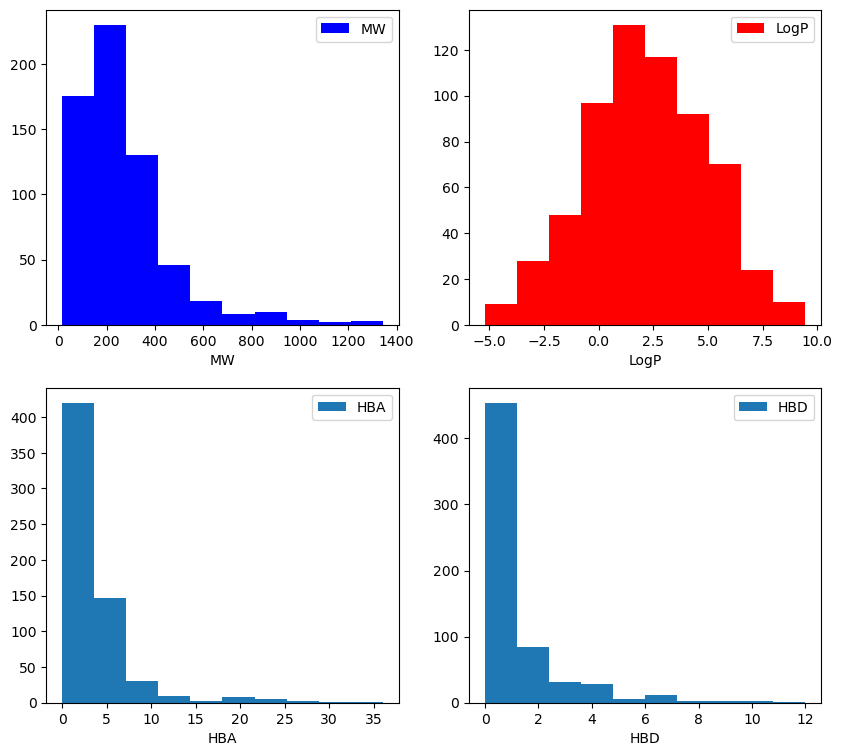

In [105]:
f, ax = plt.subplots(2,2, figsize = (10,9))
ax[0][0].hist(opera_df['MolWeight'], label = 'MW', color = 'blue')
ax[0][0].set_xlabel('MW')
ax[0][0].legend()
ax[0][1].hist(opera_df['LogP_pred'], label = 'LogP', color = 'red')
ax[0][1].set_xlabel('LogP')
ax[0][1].legend()
ax[1][0].hist(opera_df['nbHBdAcc'], label = 'HBA')
ax[1][0].set_xlabel('HBA')
ax[1][0].legend()
ax[1][1].hist(opera_df['ndHBdDon'], label = 'HBD')
ax[1][1].set_xlabel('HBD')
ax[1][1].legend()
#f.savefig(figures_dir+'Physicochemical_distributions.png', dpi = 300);

In [106]:
physchem = opera_df.copy()

In [107]:
physchem.columns

Index(['MolWeight', 'nbHBdAcc', 'ndHBdDon', 'LogP_pred'], dtype='object')

In [108]:
from sklearn.preprocessing import MinMaxScaler

In [109]:
scaler= MinMaxScaler()

In [110]:
physchem2 = pd.DataFrame(scaler.fit_transform(physchem), columns = ['MolWeight', 'nbHBdAcc', 'ndHBdDon', 'LogP_pred'], index = physchem.index)

In [111]:
from scipy.spatial import distance

In [112]:
def distance_matrix_euclidean(df):
    '''
    Function to create a pairwise square distance matrix using the Jaccard index
    '''
    D_phys = pd.DataFrame(squareform(pdist(df, 'euclidean')), columns = df.index, index = df.index)

    return D_phys

In [113]:
S_physchem = 1- (distance_matrix_euclidean(physchem2))
S_physchem

MoleculeID,DTXSID3026932,DTXSID4025402,DTXSID6025804,DTXSID9025796,DTXSID0044496,DTXSID00861835,DTXSID2020844,DTXSID5027512,DTXSID5027566,DTXSID4027367,...,DTXSID1047609,DTXSID0029268,DTXSID801023845,DTXSID5041439,DTXSID4020539,DTXSID6040111,DTXSID4042206,DTXSID501104446,DTXSID5038830,DTXSID9074355
MoleculeID,,,,,,,,,,,,,,,,,,,,,
DTXSID3026932,1.000000,0.660528,0.742975,0.808253,0.645160,0.552289,0.530175,0.446905,0.684199,0.924262,...,0.558217,0.375204,-0.258235,0.680777,0.638236,0.554771,0.734557,0.747302,0.765924,0.415685
DTXSID4025402,0.660528,1.000000,0.916673,0.848764,0.909452,0.693100,0.851403,0.751058,0.788450,0.734147,...,0.864629,0.432977,-0.141011,0.882045,0.903156,0.870243,0.850279,0.639633,0.853381,0.692827
DTXSID6025804,0.742975,0.916673,1.000000,0.931977,0.868682,0.677788,0.774949,0.678819,0.797801,0.817200,...,0.794992,0.428305,-0.168472,0.872572,0.859343,0.796877,0.877327,0.687389,0.901062,0.631082
DTXSID9025796,0.808253,0.848764,0.931977,1.000000,0.811245,0.647308,0.709024,0.615095,0.776259,0.883569,...,0.731012,0.411474,-0.197879,0.828336,0.801285,0.731731,0.856869,0.708923,0.893468,0.574038
DTXSID0044496,0.645160,0.909452,0.868682,0.811245,1.000000,0.761288,0.880446,0.800509,0.854489,0.711806,...,0.912040,0.516675,-0.062168,0.949789,0.964790,0.906005,0.894086,0.679724,0.875307,0.734609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID6040111,0.554771,0.870243,0.796877,0.731731,0.906005,0.733610,0.974422,0.879258,0.779259,0.624124,...,0.980370,0.489383,-0.048994,0.859035,0.903629,1.000000,0.800940,0.594717,0.781846,0.789686
DTXSID4042206,0.734557,0.850279,0.877327,0.856869,0.894086,0.762713,0.775395,0.707311,0.913225,0.791111,...,0.809777,0.542129,-0.073547,0.941141,0.888179,0.800940,1.000000,0.777762,0.958251,0.656850
DTXSID501104446,0.747302,0.639633,0.687389,0.708923,0.679724,0.685090,0.570562,0.528877,0.810963,0.742286,...,0.608473,0.578012,-0.076711,0.729647,0.686602,0.594717,0.777762,1.000000,0.767580,0.490219


In [114]:
d = S_physchem.copy()

In [115]:
d.index.name = None

In [116]:
d.columns.name = None

In [117]:
d

,DTXSID3026932,DTXSID4025402,DTXSID6025804,DTXSID9025796,DTXSID0044496,DTXSID00861835,DTXSID2020844,DTXSID5027512,DTXSID5027566,DTXSID4027367,...,DTXSID1047609,DTXSID0029268,DTXSID801023845,DTXSID5041439,DTXSID4020539,DTXSID6040111,DTXSID4042206,DTXSID501104446,DTXSID5038830,DTXSID9074355
DTXSID3026932,1.000000,0.660528,0.742975,0.808253,0.645160,0.552289,0.530175,0.446905,0.684199,0.924262,...,0.558217,0.375204,-0.258235,0.680777,0.638236,0.554771,0.734557,0.747302,0.765924,0.415685
DTXSID4025402,0.660528,1.000000,0.916673,0.848764,0.909452,0.693100,0.851403,0.751058,0.788450,0.734147,...,0.864629,0.432977,-0.141011,0.882045,0.903156,0.870243,0.850279,0.639633,0.853381,0.692827
DTXSID6025804,0.742975,0.916673,1.000000,0.931977,0.868682,0.677788,0.774949,0.678819,0.797801,0.817200,...,0.794992,0.428305,-0.168472,0.872572,0.859343,0.796877,0.877327,0.687389,0.901062,0.631082
DTXSID9025796,0.808253,0.848764,0.931977,1.000000,0.811245,0.647308,0.709024,0.615095,0.776259,0.883569,...,0.731012,0.411474,-0.197879,0.828336,0.801285,0.731731,0.856869,0.708923,0.893468,0.574038
DTXSID0044496,0.645160,0.909452,0.868682,0.811245,1.000000,0.761288,0.880446,0.800509,0.854489,0.711806,...,0.912040,0.516675,-0.062168,0.949789,0.964790,0.906005,0.894086,0.679724,0.875307,0.734609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID6040111,0.554771,0.870243,0.796877,0.731731,0.906005,0.733610,0.974422,0.879258,0.779259,0.624124,...,0.980370,0.489383,-0.048994,0.859035,0.903629,1.000000,0.800940,0.594717,0.781846,0.789686
DTXSID4042206,0.734557,0.850279,0.877327,0.856869,0.894086,0.762713,0.775395,0.707311,0.913225,0.791111,...,0.809777,0.542129,-0.073547,0.941141,0.888179,0.800940,1.000000,0.777762,0.958251,0.656850
DTXSID501104446,0.747302,0.639633,0.687389,0.708923,0.679724,0.685090,0.570562,0.528877,0.810963,0.742286,...,0.608473,0.578012,-0.076711,0.729647,0.686602,0.594717,0.777762,1.000000,0.767580,0.490219
DTXSID5038830,0.765924,0.853381,0.901062,0.893468,0.875307,0.732860,0.756445,0.679319,0.874059,0.826613,...,0.787454,0.511551,-0.103040,0.912556,0.863738,0.781846,0.958251,0.767580,1.000000,0.633344


In [118]:
phys_dict = {}
for k, v in target_dict.items():
    try:
        a = d[d.index == k][v].values[0]
    except Exception as error:
        print(error)
    finally:
        phys_dict[k] = a

"['DTXSID6024834'] not in index"
index 0 is out of bounds for axis 0 with size 0
"['DTXSID9027073'] not in index"
index 0 is out of bounds for axis 0 with size 0
"None of [Index(['DTXSID1020194'], dtype='object')] are in the [columns]"
"None of [Index(['DTXSID5030955'], dtype='object')] are in the [columns]"
"None of [Index(['DTXSID8027292'], dtype='object')] are in the [columns]"
"None of [Index(['DTXSID0029210'], dtype='object')] are in the [columns]"
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
"None of [Index(['DTXSID80859098'], dtype='object')] are in the [columns]"
index 0 is out of bounds for axis 0 with size 0
"['DTXSID9027073'] not in index"
"['DTXSID2027090'] not in index"
"['DTXSID2029612'] not in index"
index 0 is out of bounds for axis 0 with size 0
"None of [Index(['DTXSID6029628'], dtype='object')] are in the [columns]"
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
"['DTX

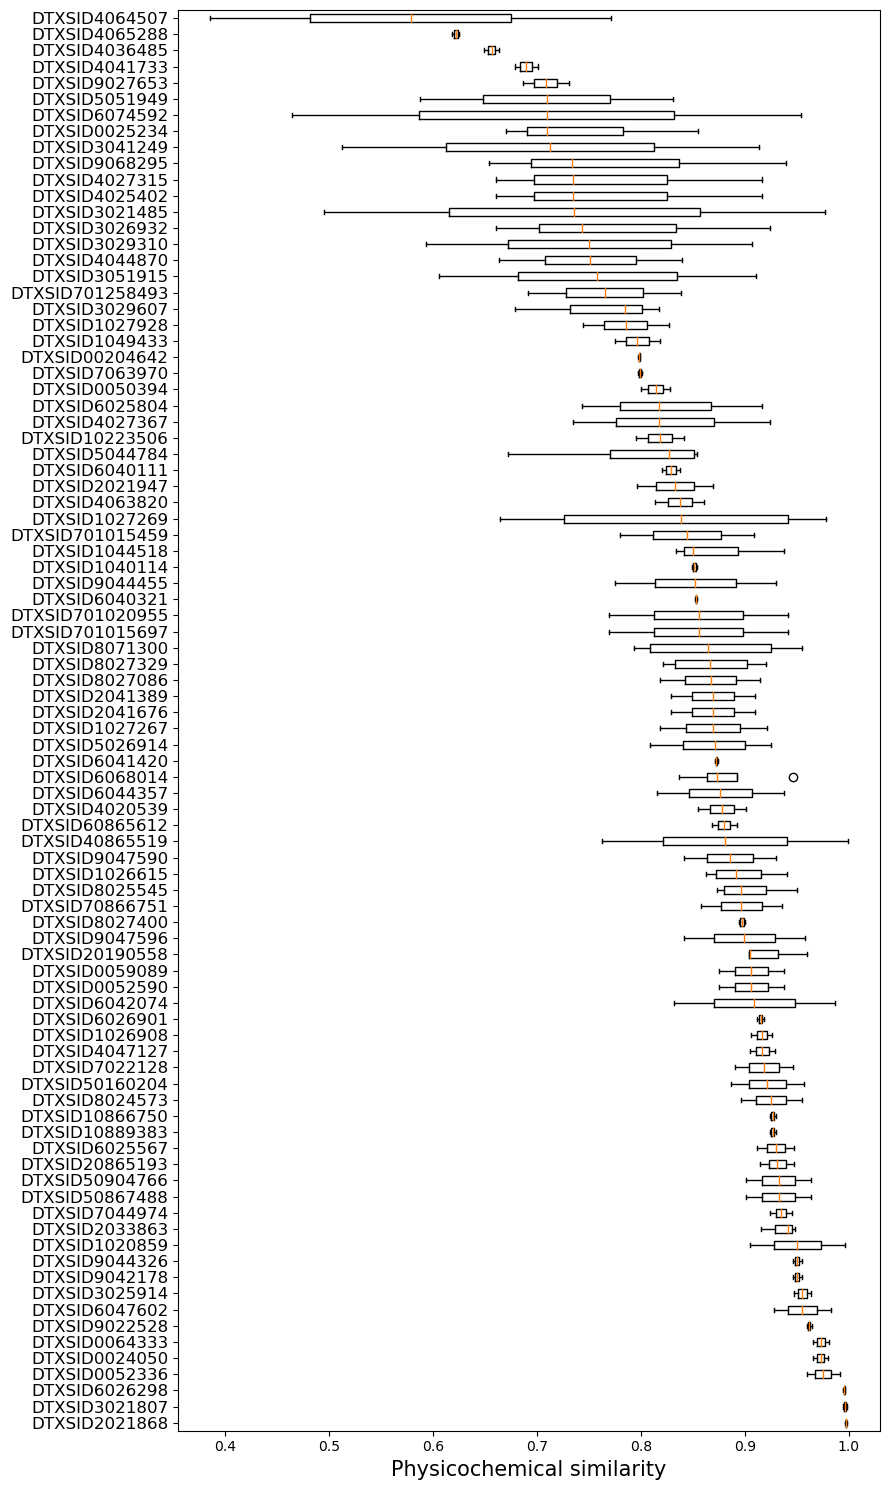

In [134]:
new_df2 = pd.DataFrame({k:v for k,v in phys_dict.items() if len(v) >1}.items())
new_df2['meds'] = [np.median(e) for e in new_df2[1]]
new_df2 = new_df2.sort_values(by = 'meds', ascending = False)


fig, ax = plt.subplots(figsize = (9,15))
labels2, data2 = list(zip((new_df2[0].values, new_df2[1].values)))
ax.boxplot(data2[0], vert = False)
plt.yticks(range(1, len(labels2[0]) +1), labels2[0], fontsize = 12)
plt.xlabel('Physicochemical similarity', fontsize = 15)
plt.tight_layout()
fig.savefig(figures_dir+'Jaccard physicochemical similarity_220224.png', dpi = 300)

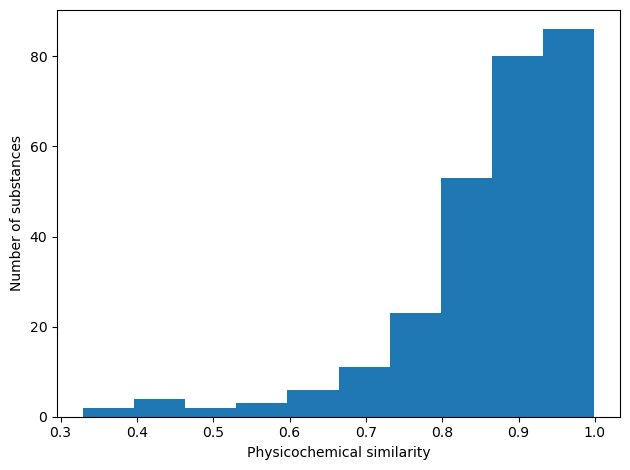

In [135]:
plt.hist({k:v[0] for k,v in phys_dict.items() }.values())
plt.xlabel('Physicochemical similarity')
plt.ylabel('Number of substances')
plt.tight_layout()
plt.savefig(figures_dir+'Tanimoto_similarity_source_phys_200224.png', dpi = 300)

In [136]:
np.median(list({k:v[0] for k,v in phys_dict.items() }.values()))

0.8994066938816327

In [137]:
S_react = pd.read_csv(processed_dir+'Sreact_reachpairs_200224.csv', index_col = [0])


In [138]:
S_react

,DTXSID8027292,DTXSID3026932,DTXSID4025402,DTXSID6025804,DTXSID9025796,DTXSID2020630,DTXSID0044496,DTXSID00861835,DTXSID2020844,DTXSID5027512,...,DTXSID801023845,DTXSID5041439,DTXSID4020539,DTXSID60894063,DTXSID6040111,DTXSID4049664,DTXSID4042206,DTXSID501104446,DTXSID5038830,DTXSID9074355
DTXSID8027292,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
DTXSID3026932,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
DTXSID4025402,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
DTXSID6025804,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
DTXSID9025796,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID4049664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
DTXSID4042206,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
DTXSID501104446,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
DTXSID5038830,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0


In [139]:
rxn_dict = {}
for k, v in target_dict.items():
    a = S_react[S_react.index == k][v].values[0]
    rxn_dict[k] = a

In [140]:
WL = pd.read_csv(processed_dir+'WL_TIMES_300623.csv', index_col = [0])
S_metab = pd.read_csv(processed_dir+'Stransformations_300623.csv', index_col = [0])
S_metabs = pd.read_csv(processed_dir+'Smetabolites_300623.csv', index_col = [0])

In [141]:
WL_dict = {}
for k, v in target_dict.items():
    a = WL[WL.index == k][v].values[0]
    WL_dict[k] = a

In [142]:
S_metab_dict = {}
for k, v in target_dict.items():
    a = S_metab[S_metab.index == k][v].values[0]
    S_metab_dict[k] = a


In [143]:
S_metabs_dict = {}
for k, v in target_dict.items():
    a = S_metabs[S_metabs.index == k][v].values[0]
    S_metabs_dict[k] = a


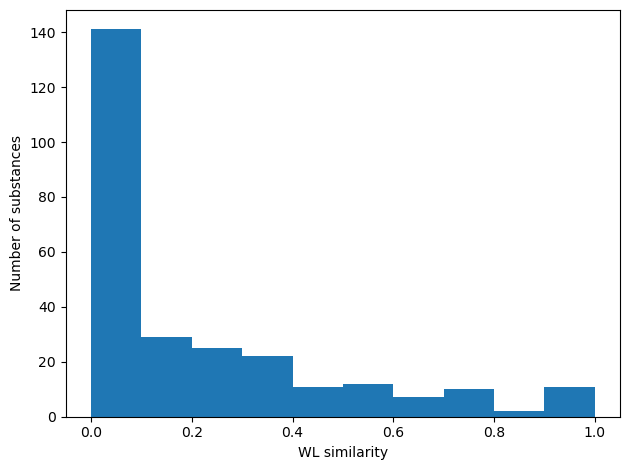

In [144]:
plt.hist({k:v[0] for k,v in WL_dict.items() }.values())
plt.xlabel('WL similarity')
plt.ylabel('Number of substances')
plt.tight_layout()
#plt.savefig(figures_dir+'WL_TIMES_300623.png', dpi = 300)


In [145]:
np.median(list({k:v[0] for k,v in WL_dict.items() }.values()))

0.08490492697086685

In [146]:
np.median(list({k:v[0] for k,v in S_metab_dict.items() }.values()))

0.1428571428571429

In [147]:
S_metabs_dict
np.median(list({k:v[0] for k,v in S_metabs_dict.items() }.values()))

0.0

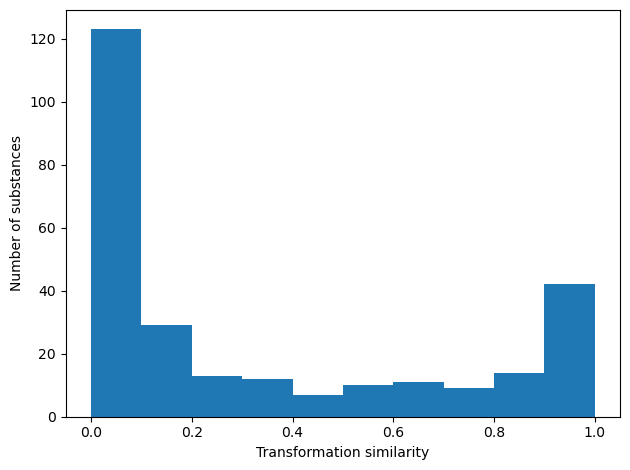

In [148]:
plt.hist({k:v[0] for k,v in S_metab_dict.items() }.values())
plt.xlabel('Transformation similarity')
plt.ylabel('Number of substances')
plt.tight_layout()
#plt.savefig(figures_dir+'Transformations_TIMES_300623.png', dpi = 300)


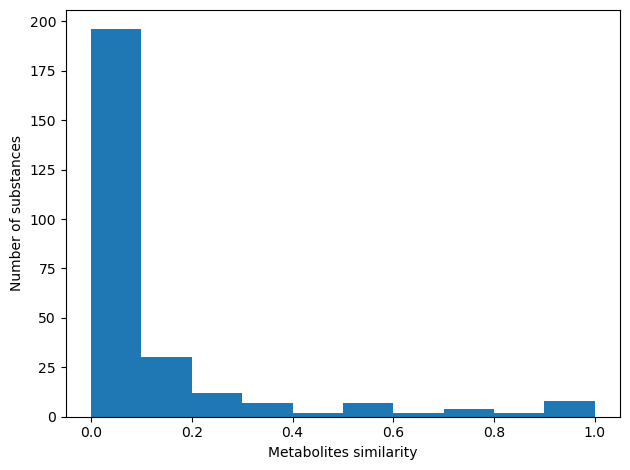

In [149]:
plt.hist({k:v[0] for k,v in S_metabs_dict.items() }.values())
plt.xlabel('Metabolites similarity')
plt.ylabel('Number of substances')
plt.tight_layout()
#plt.savefig(figures_dir+'Metabolites_TIMES_300623.png', dpi = 300)


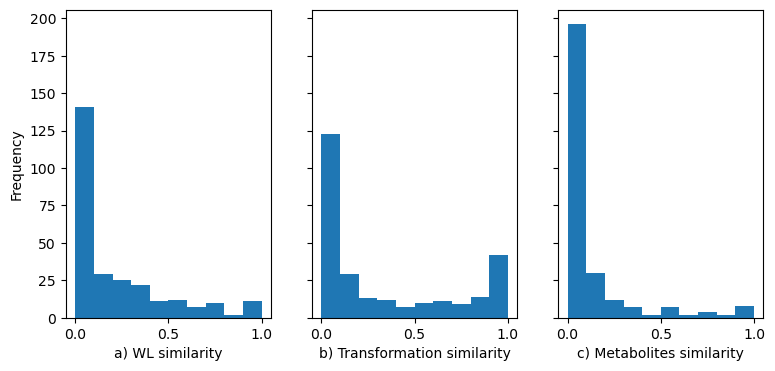

In [151]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (9,4), sharey = True)
ax1.hist({k:v[0] for k,v in WL_dict.items() }.values())
ax1.set_xlabel('a) WL similarity')
ax2.hist({k:v[0] for k,v in S_metab_dict.items() }.values())
ax2.set_xlabel('b) Transformation similarity')
ax3.hist({k:v[0] for k,v in S_metabs_dict.items() }.values())
ax3.set_xlabel('c) Metabolites similarity')
ax1.set_ylabel('Frequency');
f.savefig(figures_dir+'Metabolites_TIMES_220224.png', dpi = 300)

In [152]:
WL_df  = WL.stack().reset_index()
WL_df.columns = ['Target', 'Analogue', 'WL']
WL_df

,Target,Analogue,WL
0,DTXSID001014636,DTXSID001014636,1.000000
1,DTXSID001014636,DTXSID001108700,0.000000
2,DTXSID001014636,DTXSID0020078,0.000000
3,DTXSID001014636,DTXSID0020232,0.000000
4,DTXSID001014636,DTXSID00204642,0.000000
...,...,...,...
632020,DTXSID90936440,DTXSID90890659,0.000000
632021,DTXSID90936440,DTXSID90892431,0.000000
632022,DTXSID90936440,DTXSID90893645,0.735767
632023,DTXSID90936440,DTXSID90926861,0.000000


In [153]:
d

,DTXSID3026932,DTXSID4025402,DTXSID6025804,DTXSID9025796,DTXSID0044496,DTXSID00861835,DTXSID2020844,DTXSID5027512,DTXSID5027566,DTXSID4027367,...,DTXSID1047609,DTXSID0029268,DTXSID801023845,DTXSID5041439,DTXSID4020539,DTXSID6040111,DTXSID4042206,DTXSID501104446,DTXSID5038830,DTXSID9074355
DTXSID3026932,1.000000,0.660528,0.742975,0.808253,0.645160,0.552289,0.530175,0.446905,0.684199,0.924262,...,0.558217,0.375204,-0.258235,0.680777,0.638236,0.554771,0.734557,0.747302,0.765924,0.415685
DTXSID4025402,0.660528,1.000000,0.916673,0.848764,0.909452,0.693100,0.851403,0.751058,0.788450,0.734147,...,0.864629,0.432977,-0.141011,0.882045,0.903156,0.870243,0.850279,0.639633,0.853381,0.692827
DTXSID6025804,0.742975,0.916673,1.000000,0.931977,0.868682,0.677788,0.774949,0.678819,0.797801,0.817200,...,0.794992,0.428305,-0.168472,0.872572,0.859343,0.796877,0.877327,0.687389,0.901062,0.631082
DTXSID9025796,0.808253,0.848764,0.931977,1.000000,0.811245,0.647308,0.709024,0.615095,0.776259,0.883569,...,0.731012,0.411474,-0.197879,0.828336,0.801285,0.731731,0.856869,0.708923,0.893468,0.574038
DTXSID0044496,0.645160,0.909452,0.868682,0.811245,1.000000,0.761288,0.880446,0.800509,0.854489,0.711806,...,0.912040,0.516675,-0.062168,0.949789,0.964790,0.906005,0.894086,0.679724,0.875307,0.734609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DTXSID6040111,0.554771,0.870243,0.796877,0.731731,0.906005,0.733610,0.974422,0.879258,0.779259,0.624124,...,0.980370,0.489383,-0.048994,0.859035,0.903629,1.000000,0.800940,0.594717,0.781846,0.789686
DTXSID4042206,0.734557,0.850279,0.877327,0.856869,0.894086,0.762713,0.775395,0.707311,0.913225,0.791111,...,0.809777,0.542129,-0.073547,0.941141,0.888179,0.800940,1.000000,0.777762,0.958251,0.656850
DTXSID501104446,0.747302,0.639633,0.687389,0.708923,0.679724,0.685090,0.570562,0.528877,0.810963,0.742286,...,0.608473,0.578012,-0.076711,0.729647,0.686602,0.594717,0.777762,1.000000,0.767580,0.490219
DTXSID5038830,0.765924,0.853381,0.901062,0.893468,0.875307,0.732860,0.756445,0.679319,0.874059,0.826613,...,0.787454,0.511551,-0.103040,0.912556,0.863738,0.781846,0.958251,0.767580,1.000000,0.633344


In [154]:
d_df = d.stack().reset_index()
d_df.columns = ['Target', 'Analogue', 'phys_sim']

In [155]:
meta_df = S_metab.stack().reset_index()
meta_df.columns = ['Target', 'Analogue', 'transformation_sim']


In [156]:
metab_df = S_metabs.stack().reset_index()
metab_df.columns = ['Target', 'Analogue', 'metabs_sim']

In [157]:
alert_df = S_react.stack().reset_index()
alert_df.columns = ['Target', 'Analogue', 'alert_sim']

In [158]:
S_df = S.stack().reset_index()
S_df.columns = ['Target', 'Analogue', 'struct_sim']   

In [159]:
S_Derek = pd.merge(S_df, alert_df, left_on = ['Target', 'Analogue'], right_on =['Target', 'Analogue'], how = 'left')

In [160]:
temp = pd.merge(S_Derek, metab_df,  left_on = ['Target', 'Analogue'], right_on =['Target', 'Analogue'], how = 'left')

In [161]:
temp = pd.merge(temp, meta_df,  left_on = ['Target', 'Analogue'], right_on =['Target', 'Analogue'], how = 'left')

In [162]:
temp = pd.merge(temp, WL_df,  left_on = ['Target', 'Analogue'], right_on =['Target', 'Analogue'], how = 'left')

In [163]:
temp = pd.merge(temp, d_df,  left_on = ['Target', 'Analogue'], right_on =['Target', 'Analogue'], how = 'left')

In [164]:
temp2 = temp.dropna()

In [165]:
temp2 = temp2[~(temp2['Target'] == temp2['Analogue'])]

In [166]:
mylabels = []
for i,row in temp2.iterrows():
    for k,v in target_dict.items():
        if (row['Target'] == k) & (row['Analogue'] in v):
            mylabels.append([row['Target'],row['Analogue'], 1])
        elif (row['Target'] in v) & (row['Analogue'] ==k):
            mylabels.append([row['Target'],row['Analogue'], 1])
            

In [167]:
labels_df = pd.DataFrame(mylabels, columns = ['Target', 'Analogue', 'Label'])

In [168]:
final = pd.merge(temp, labels_df, left_on =['Target', 'Analogue'], right_on = ['Target', 'Analogue'], how = 'left')

In [169]:
final['Label'] = final['Label'].replace(np.nan, 0)

In [170]:
final_df = final.set_index(['Target', 'Analogue'])

In [171]:
final_df = final_df.dropna()

In [172]:
final_df.to_csv(processed_dir+'final_df_220224.csv')

In [173]:
#final_df = pd.read_csv(processed_dir+'final_df_300623.csv')
final_df

struct_sim  alert_sim  metabs_sim  \
Target        Analogue                                             
DTXSID1027269 DTXSID1027269      1.000000        1.0    1.000000   
              DTXSID5026914      1.000000        1.0    0.047619   
              DTXSID4027367      1.000000        1.0    0.061644   
              DTXSID9047596      0.196078        1.0    0.000000   
              DTXSID401036250    0.061224        0.0    0.000000   
...                                   ...        ...         ...   
DTXSID4042254 DTXSID3041877      0.081967        1.0    0.000000   
              DTXSID1024835      0.036364        1.0    0.000000   
              DTXSID1021324      0.025000        1.0    0.000000   
              DTXSID3026514      0.019608        1.0    0.000000   
              DTXSID4042254      1.000000        1.0    1.000000   

                               transformation_sim        WL  phys_sim  Label  
Target        Analogue                                                        
DTXSID1027269 DTXSID1027269              1.000000  1.000000  1.000000    0.0  
              DTXSID5026914              0.866667  0.155979  0.855037    0.0  
              DTXSID4027367              0.866667  0.144200  0.929802    1.0  
              DTXSID9047596              0.000000  0.046260  0.681655    0.0  
              DTXSID401036250            0.150000  0.071651  0.644544    0.0  
...                                           ...       ...       ...    ...  
DTXSID4042254 DTXSID3041877              0.000000  0.140264  0.789391    0.0  
              DTXSID1024835              0.000000  0.110274  0.694941    0.0  
              DTXSID1021324              0.000000  0.000000  0.637881    0.0  
              DTXSID3026514              0.000000  0.025903  0.698762    0.0  
              DTXSID4042254              1.000000  1.000000  1.000000    0.0  

[234278 rows x 7 columns]

In [174]:
#final_df = final_df.set_index(['Target', 'Analogue'])

In [175]:
y = final_df['Label']

In [176]:
X = final_df.drop(['Label'], axis = 1)

In [177]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = 42)

In [178]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, f1_score, make_scorer, roc_auc_score
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import matthews_corrcoef, roc_auc_score, precision_score, f1_score, recall_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [179]:
cv = StratifiedKFold(n_splits = 10)
scorer = make_scorer(balanced_accuracy_score)

In [180]:
import warnings 
from sklearn.exceptions import ConvergenceWarning

# Filter out warnings from models
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore', category = DeprecationWarning)
warnings.filterwarnings('ignore', category = UserWarning)

# Dataframe to hold results
model_results = pd.DataFrame(columns = ['model', 'cv_BA_mean', 'cv_BA_std', 'cv_F1_mean', 'cv_F1_std','cv_MCC_mean','cv_MCC_std','cv_Recall_mean','cv_Recall_std',])

def cv_model(train, train_labels, model, name, model_results=None):
    """Perform 10 fold cross validation of a model"""
    scorer = {'BA' : make_scorer(balanced_accuracy_score) ,'F1': make_scorer(f1_score), 'MCC' : make_scorer(matthews_corrcoef), 'Recall' : make_scorer(recall_score)}
    cv = StratifiedKFold(n_splits = 10)
    cv_scores = cross_validate(model, train, train_labels, cv = cv, scoring=scorer, n_jobs = -1)
    cv_scores = pd.DataFrame(cv_scores)
    
    
    if model_results is not None:
        model_results = model_results.append(pd.DataFrame({'model': name, 
                                                           'cv_BA_mean': cv_scores['test_BA'].mean(), 
                                                            'cv_BA_std': cv_scores['test_BA'].std(),
                                                          'cv_F1_mean': cv_scores['test_F1'].mean(), 
                                                            'cv_F1_std': cv_scores['test_F1'].std(),
                                                           'cv_MCC_mean': cv_scores['test_MCC'].mean(), 
                                                            'cv_MCC_std': cv_scores['test_MCC'].std(),
                                                           'cv_Recall_mean': cv_scores['test_Recall'].mean(), 
                                                            'cv_Recall_std': cv_scores['test_Recall'].std()
                                                          },
                                                           index = [0]),
                                             ignore_index = True)

        return model_results

In [181]:
model_results = cv_model(X_train, y_train, LogisticRegression(), 
                         'LR', model_results)

/tmp/ipykernel_952584/4167089468.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [182]:
model_results = cv_model(X_train, y_train,
                          LinearDiscriminantAnalysis(), 
                          'LDA', model_results)


/tmp/ipykernel_952584/4167089468.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [183]:
model_results = cv_model(X_train, y_train,
                         RidgeClassifierCV(), 'RIDGE', model_results)

/tmp/ipykernel_952584/4167089468.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


In [184]:
model_results = cv_model(X_train, y_train,
                         RandomForestClassifier(n_estimators = 100, max_samples = 0.66, random_state = 42), 'RFC', model_results)

/tmp/ipykernel_952584/4167089468.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_results = model_results.append(pd.DataFrame({'model': name,


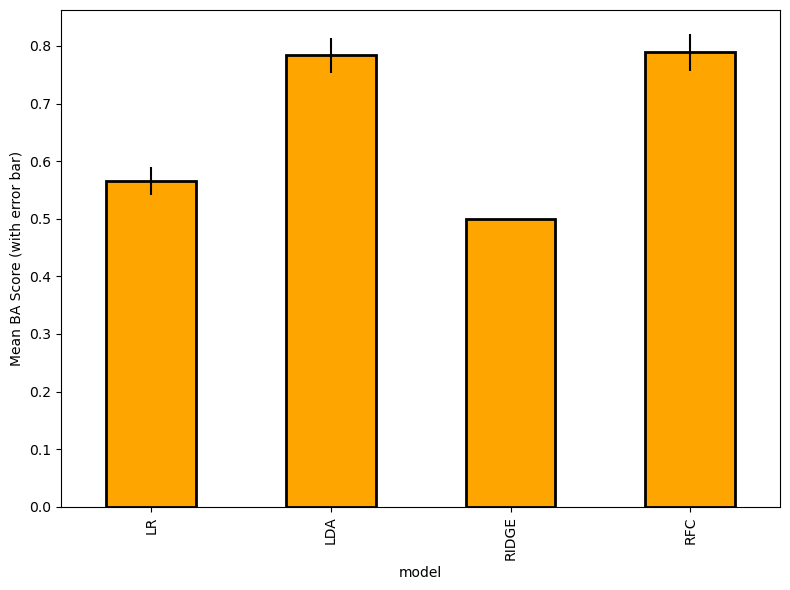

In [185]:
model_results.set_index('model', inplace = True)
model_results['cv_BA_mean'].plot.bar(color = 'orange', figsize = (8, 6),
                                  yerr = list(model_results['cv_BA_std']),
                                  edgecolor = 'k', linewidth = 2)
#plt.title('Model AUC Score Results');
plt.ylabel('Mean BA Score (with error bar)');
model_results.reset_index(inplace = True)
plt.tight_layout()


In [186]:
model_results

,model,cv_BA_mean,cv_BA_std,cv_F1_mean,cv_F1_std,cv_MCC_mean,cv_MCC_std,cv_Recall_mean,cv_Recall_std
0,LR,0.565477,0.024520,0.208444,0.070436,0.264633,0.073834,0.131307,0.049058
1,LDA,0.783704,0.030372,0.225387,0.023985,0.280467,0.030008,0.578433,0.060635
2,RIDGE,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,RFC,0.789170,0.032242,0.713129,0.044185,0.735231,0.035092,0.578463,0.064551


In [187]:
rfc = RandomForestClassifier(n_estimators = 100, max_samples = 0.66, random_state = 42)

In [188]:
cv_results = cross_validate(rfc, X_train, y_train , cv=StratifiedKFold(n_splits = 10) ,scoring = make_scorer(balanced_accuracy_score), return_train_score = True)

In [189]:
cv_results['test_score'].mean()

0.7891701510959771

In [190]:
cv_results = pd.DataFrame(cv_results)

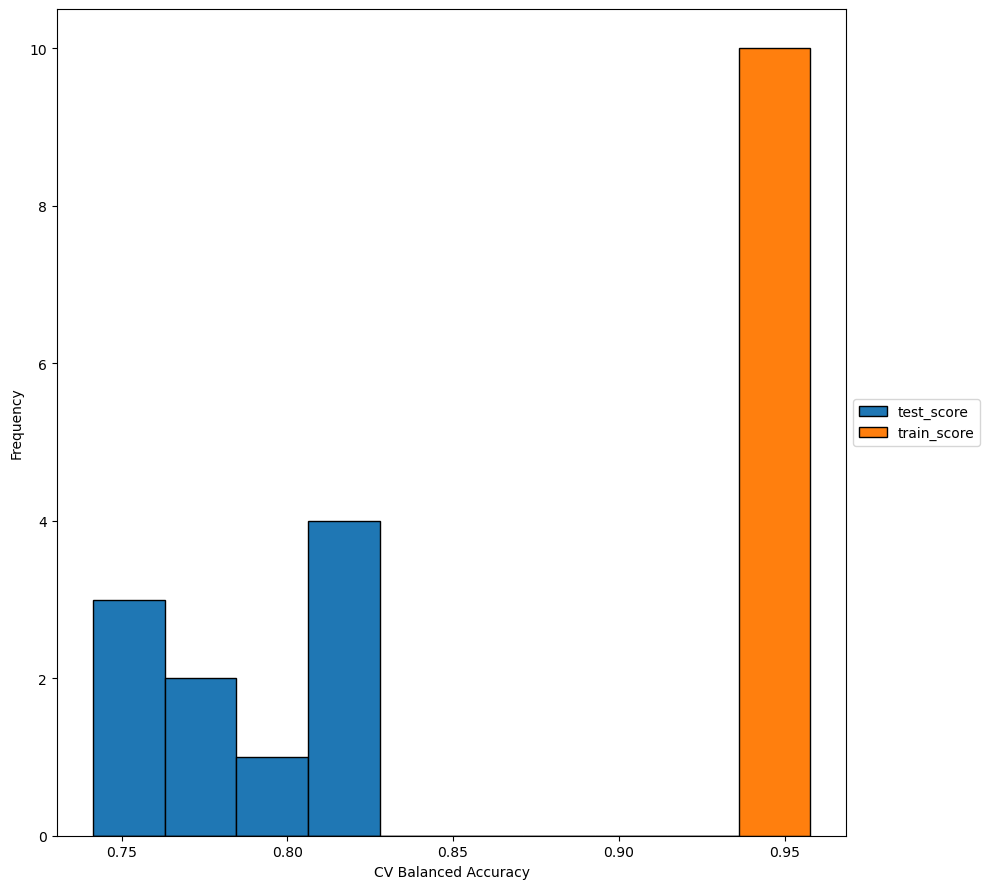

In [191]:
cv_results[['test_score', 'train_score']].plot.hist(edgecolor = 'black', figsize = (10,9))
plt.xlabel('CV Balanced Accuracy')
plt.legend(loc = 'center left', bbox_to_anchor = (1,0.5))
plt.tight_layout()

In [192]:
from sklearn.model_selection import validation_curve
rf = RandomForestClassifier(max_samples = 0.66, random_state = 42)
n_estimators = [1,5, 10, 25, 50, 75, 100, 150,200,500]
train_scores, test_scores = validation_curve(
    rf, X_train, y_train, param_name="n_estimators", param_range=n_estimators,
    scoring=make_scorer(balanced_accuracy_score), cv=StratifiedKFold(n_splits = 10), n_jobs=-1)

Text(0, 0.5, 'Balanced Accuracy (mean)')

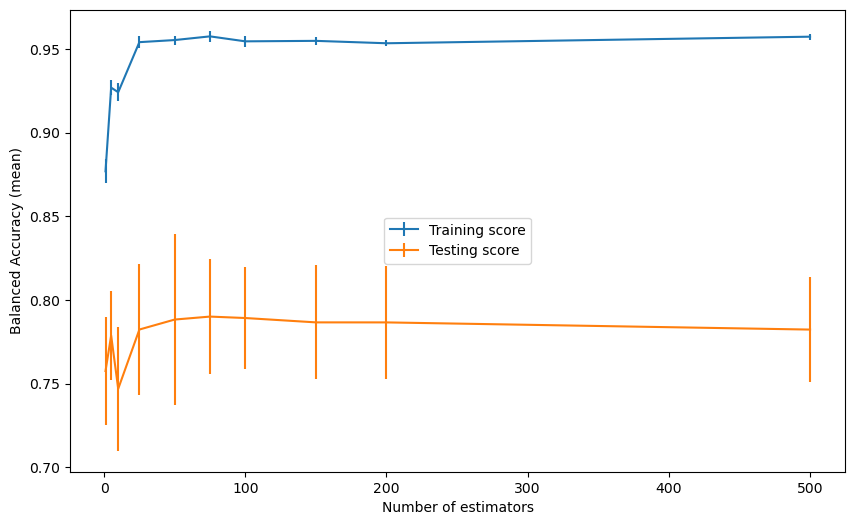

In [193]:
plt.figure(figsize = (10,6))
plt.errorbar(n_estimators, train_scores.mean(axis=1),
             yerr=train_scores.std(axis=1), label='Training score')
plt.errorbar(n_estimators, test_scores.mean(axis=1),
             yerr=test_scores.std(axis=1), label='Testing score')
plt.legend(loc = 'center')

plt.xlabel("Number of estimators")
plt.ylabel("Balanced Accuracy (mean)")

In [194]:
grid = {
    "n_estimators": [20, 50, 75,100],
    "max_leaf_nodes": [5,10,20, 50],
}


In [195]:
from sklearn.model_selection import GridSearchCV

In [196]:
inner_cv = StratifiedKFold(n_splits = 10)
outer_cv = StratifiedKFold(n_splits = 10)

In [197]:
search=GridSearchCV(RandomForestClassifier(random_state=42, max_samples = 0.66), grid, scoring=make_scorer(balanced_accuracy_score), cv=inner_cv, n_jobs=-1 )


In [198]:
cv_results = cross_validate(search, X_train, y_train, cv=outer_cv, scoring = make_scorer(balanced_accuracy_score), n_jobs=-1 )


In [200]:
cv_results['test_score'].mean(), cv_results['test_score'].std()

(0.6112912357046042, 0.028591061939976237)

In [201]:
cv_results

{'fit_time': array([810.84130001, 807.87688398, 808.14348698, 812.39926171,
        814.32613873, 817.4022913 , 811.05622315, 809.36297941,
        189.8557868 , 190.95087624]),
 'score_time': array([0.22691894, 0.08345866, 0.04684901, 0.11117482, 0.16242385,
        0.18218207, 0.13125396, 0.24265003, 0.04017091, 0.04830694]),
 'test_score': array([0.59464027, 0.61206897, 0.58769254, 0.65509213, 0.62925682,
        0.6464982 , 0.59477406, 0.59477406, 0.63787751, 0.56023778])}

In [202]:
search.fit(X_train, y_train).best_params_

{'max_leaf_nodes': 50, 'n_estimators': 100}

In [203]:
final_model = RandomForestClassifier(random_state=42, max_samples = 0.66,max_leaf_nodes=50, n_estimators=100 )

In [204]:
final_model.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=50, max_samples=0.66, random_state=42)

In [205]:
import pickle
filename = 'finalized_model_RFC_220224.sav'
pickle.dump(final_model, open(external_dir+filename, 'wb'))

In [206]:
final_model.feature_importances_

array([0.39186449, 0.01584799, 0.13986006, 0.13096672, 0.13585699,
       0.18560376])

In [207]:
final_model.feature_names_in_.tolist()

['struct_sim',
 'alert_sim',
 'metabs_sim',
 'transformation_sim',
 'WL',
 'phys_sim']

In [208]:
final_model.feature_importances_.tolist()

[0.3918644924651369,
 0.015847985035264266,
 0.1398600594934425,
 0.1309667150828734,
 0.13585699263659257,
 0.18560375528669046]

In [209]:
final_model.feature_names_in_.T

array(['struct_sim', 'alert_sim', 'metabs_sim', 'transformation_sim',
       'WL', 'phys_sim'], dtype=object)

In [210]:
myco = []
for x,y in zip(final_model.feature_names_in_.tolist(), final_model.feature_importances_.tolist()):
    myco.append([x,y])
    

In [211]:
pd.DataFrame(myco, columns = ['similarities', 'feature-importances'])

,similarities,feature-importances
0,struct_sim,0.391864
1,alert_sim,0.015848
2,metabs_sim,0.139860
3,transformation_sim,0.130967
4,WL,0.135857
5,phys_sim,0.185604


In [212]:
preds = final_model.predict(X_test)

In [213]:
balanced_accuracy_score(y_test, preds)

0.6206468387052005

In [214]:
param_grid=dict()
param_grid['solver']=['svd', 'lsqr', 'eigen']

In [215]:
inner_cv = StratifiedKFold(n_splits = 10)
outer_cv = StratifiedKFold(n_splits = 10)

In [216]:
model_to_tune=GridSearchCV(LinearDiscriminantAnalysis(), param_grid, scoring=make_scorer(balanced_accuracy_score), cv=inner_cv, n_jobs=-1 )

In [217]:
cv_results2 = cross_validate(model_to_tune, X_train, y_train, cv=outer_cv, scoring = make_scorer(balanced_accuracy_score), n_jobs=-1 )

In [218]:
cv_results2['test_score'].mean(), cv_results2['test_score'].std()

(0.7837039238267561, 0.02881348352706835)

In [219]:
model_to_tune.fit(X_train, y_train).best_params_

{'solver': 'svd'}

In [220]:
final_model2 = LinearDiscriminantAnalysis(solver = 'svd')

In [221]:
final_model2.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [222]:
final_model2.coef_

array([[ 59.77172725,   0.1813803 , -48.79946849,  22.44192211,
          4.88710264,  -0.32948767]])

In [223]:
final_model2.feature_names_in_.tolist()

['struct_sim',
 'alert_sim',
 'metabs_sim',
 'transformation_sim',
 'WL',
 'phys_sim']

In [224]:
final_model2.coef_.tolist()[0]

[59.77172725330048,
 0.18138030120765883,
 -48.79946849322166,
 22.441922110476508,
 4.887102635429935,
 -0.3294876678055169]

In [225]:
final_model2.feature_names_in_.T

array(['struct_sim', 'alert_sim', 'metabs_sim', 'transformation_sim',
       'WL', 'phys_sim'], dtype=object)

In [226]:
myco2 = []
for x,y in zip(final_model2.feature_names_in_.tolist(), final_model2.coef_.tolist()[0]):
    myco2.append([x,y])

In [227]:
pd.DataFrame(myco2, columns = ['similarities', 'coefficients'])

,similarities,coefficients
0,struct_sim,59.771727
1,alert_sim,0.181380
2,metabs_sim,-48.799468
3,transformation_sim,22.441922
4,WL,4.887103
5,phys_sim,-0.329488


In [228]:
preds2 = final_model2.predict(X_test)

In [229]:
balanced_accuracy_score(y_test, preds2)

0.7799663964553871

In [230]:
filename = 'finalized_model_LDA_220224.sav'
pickle.dump(final_model, open(external_dir+filename, 'wb'))